# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Import a bunch of libraries.
import time
import numpy as np
import numpy
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split


# Set the randomizer seed so results are the same each time.
np.random.seed(0)
print("loading complete")

loading complete


In [2]:
### using s3fs to get public bucket contents

%pip install fs_s3fs --quiet
%pip install s3fs --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import s3fs # so we can access public s3 buckets


Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [4]:
# this is my bootcamp bucket
mnist_train = pd.read_csv("s3://btcampdata/mnist/mnist_train.csv")
mnist_test = pd.read_csv("s3://btcampdata/mnist/mnist_test.csv")

mnist_dataset = pd.concat([mnist_train, mnist_test])

Y = mnist_dataset['label']
X = mnist_dataset.drop(columns=['label'])

In [5]:
type(X)

pandas.core.frame.DataFrame

In [6]:
# Scale images to the [0, 1] range
X = X.astype("float32") / 255

#fix - already numpy
X = X.to_numpy()
Y = Y.to_numpy()

In [7]:
print ('data shape: ', X.shape)
print ('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

print ("\n-->","cell complete")
print ("Data: ",type(X[1]), len(X[1])," features")

data shape:  (70000, 784)
label shape: (70000,)

--> cell complete
Data:  <class 'numpy.ndarray'> 784  features


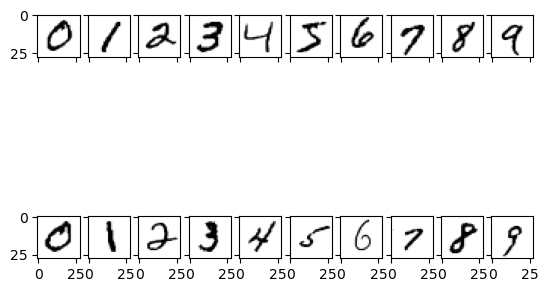

In [8]:
def P1(num_examples=10,):
### STUDENT START ###

    # get list of examples (stored as ist of lists)

    examples = []
    for j in range(10):
        examplelist = []
        for i in range(len(Y)):
            if Y[i] == j:
                examplelist.append(i)
                if num_examples == len(examplelist):
                    break
        examples.append(examplelist)
        # plot examples
    f, plots = plt.subplots(num_examples,10, sharex='col', sharey='row')

    for i, examplelist in enumerate(examples):
        #unpack examples, index, and assign to subplots
        for j, example in enumerate(examplelist):
            plots[j][i].imshow(numpy.reshape(X[example],(28,28)),cmap="Greys")
    plt.show()


### STUDENT END ###

P1(2)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [9]:
def P2(k_values):

### STUDENT START ###

### note: using accuracy calculated manually as
### number of matches (number right)/total, not
### the .score() method/function

    for k in reversed(k_values):
        #reversed order, classify, predict, then print accuracy
        #print classification report when k=1
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier = classifier.fit(mini_train_data, mini_train_labels)
        predicted = classifier.predict(dev_data)
        res = sum(predicted == dev_labels)*1./len(dev_labels)
        print("accuracy at k=",k,"-> ", res)

        #skip classification report except at k==1
        if k!=1:
            continue
        print("\nClassification report @k=1:")
        print(classification_report(dev_labels, predicted))
        print("Most difficult digit: #7")
### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

accuracy at k= 9 ->  0.809
accuracy at k= 7 ->  0.805
accuracy at k= 5 ->  0.815
accuracy at k= 3 ->  0.814
accuracy at k= 1 ->  0.828

Classification report @k=1:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        85
           1       0.88      1.00      0.93       126
           2       0.92      0.79      0.85       116
           3       0.85      0.71      0.78       107
           4       0.87      0.72      0.79       110
           5       0.72      0.72      0.72        87
           6       0.84      0.93      0.89        87
           7       0.80      0.90      0.85        99
           8       0.88      0.65      0.75        89
           9       0.67      0.89      0.77        94

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.82      1000
weighted avg       0.84      0.83      0.83      1000

Most difficult digit: #7


ANSWER: Most difficult digit: #7

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [10]:
def P3(train_sizes, accuracies):

### STUDENT START ###
    print ("Size\t\tAccuracy\t\tTime (ms)")
    for size in train_sizes:
        start = time.time()
        classifier = KNeighborsClassifier(n_neighbors=1).fit(mini_train_data[:size], mini_train_labels[:size])
        predicted = classifier.predict(dev_data)
        accuracy = sum(predicted == dev_labels)*1./len(dev_labels)
        print("{}\t\t{}\t\t\t{}".format(size, accuracy, (time.time() - start)*1000))
        accuracies.append(accuracy)



### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Size		Accuracy		Time (ms)
100		0.631			131.52337074279785
200		0.691			109.06267166137695
400		0.777			123.20590019226074
800		0.822			176.7714023590088
1600		0.828			135.6222629547119
3200		0.828			138.41938972473145
6400		0.828			141.85786247253418
12800		0.828			151.70669555664062
25000		0.828			137.33482360839844


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

In [11]:
from math import sqrt


def P4():

### STUDENT START ###
    lm = LinearRegression()

    sizes = np.array(train_sizes)
    acc = np.array(accuracies)
    sizes = np.array(train_sizes)
    #change type for fit() args
    lm.fit( sizes.reshape((9,1)), acc)

    reshaped_array = np.array([60000]).reshape(1, -1)
    print(reshaped_array)
    print ("Predicted (linear regression) at 60000: ", lm.predict(reshaped_array)[0])

    print ("----Modifying with sqrt transformation----")
    train_sizes2 = list(map(sqrt, train_sizes))
    #apply sqrt to list
    sizes2 = np.array(train_sizes2)
    lm.fit(sizes2.reshape((9,1)), acc)
    #re-train
    sqrt_num = sqrt(reshaped_array)
    reshaped_array_with_sqrt = np.array([sqrt_num]).reshape(1, -1)
    print ("New, Predicted  at 60000: ",lm.predict(reshaped_array_with_sqrt)[0])

### STUDENT END ###

P4()

[[60000]]
Predicted (linear regression) at 60000:  0.9905833597841612
----Modifying with sqrt transformation----
New, Predicted  at 60000:  0.9449247051923593


Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

In [ ]:
def P5():

### STUDENT START ###
    classifier = KNeighborsClassifier(n_neighbors=1).fit(mini_train_data, mini_train_labels)
    predicted = classifier.predict(dev_data)
    print (confusion_matrix(dev_labels,predicted))

    #get list of misclassified
    x=[i for i in range(len(dev_labels)) if (dev_labels[i]==4) and (predicted[i]==9)]

    #plot examples
    f, plots = plt.subplots(3,3, sharex='col', sharey='row')
    for i, plotrow in enumerate(plots):
        for j, subplot in enumerate(plotrow):
            plots[j][i].imshow(numpy.reshape(dev_data[x[i+3*j]],(28,28)),cmap="Greys")
    plt.show()



P5()

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [13]:
def blur_one(img):
    def append_point(point):
        """ Deal with out of bounds points """
        if -1 in point: return
        try:
            points.append(img[point[0]][point[1]])
        except:
            pass

    img = img.reshape(28, 28)
    blurred_img = np.ndarray(shape=(784))
    for i in range(28):
        for j in range(28):
            points = [img[i][j]]
            append_point((i+1, j  ))
            append_point((i-1, j  ))
            append_point((i,   j+1))
            append_point((i,   j-1))
            append_point((i+1, j+1))
            append_point((i-1, j-1))
            append_point((i+1, j-1))
            append_point((i-1, j+1))
            blurred_img[28*i+j] = sum(points)/len(points)

    return blurred_img

#cite: blurring function from w207 summer '15 class
def P6():

### STUDENT START ###

    # create blurred data sets

    blurred_train_data = []
    for pic in mini_train_data:
        blurred_train_data.append(blur_one(pic))
    blurred_dev_data = []
    for pic in dev_data:
        blurred_dev_data.append(blur_one(pic))

    # test combinations of blurred/un-blurred
    test_order = ["No Blur",
                  "Blurred Training Daya",
                  "Blurred Test/Dev Data",
                  "Both Data Sets Blurred"]
    testnum=0
    for devdata in (dev_data,blurred_dev_data):
        for traindata in (mini_train_data,blurred_train_data):
            classifier = KNeighborsClassifier(n_neighbors=1).fit(traindata, mini_train_labels)
            predicted = classifier.predict(devdata)
            accuracy = sum(predicted == dev_labels)*1./len(dev_labels)
            print (accuracy, " accuracy in test with", test_order[testnum])
            testnum+=1


        ### STUDENT END ###

P6()

0.828  accuracy in test with No Blur
0.854  accuracy in test with Blurred Training Daya
0.824  accuracy in test with Blurred Test/Dev Data
0.858  accuracy in test with Both Data Sets Blurred


ANSWER: 0.828  - No Blur
        0.854  - Blurred Training Daya
        0.824  - Blurred Test/Dev Data
        0.858  - Both Blurred

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [14]:
def P7():

### STUDENT START ###

    # create binary data
    binary_mini_train_data = []
    for pic in mini_train_data:
        binary_mini_train_data.append(pic//.5)

    binary_dev_data = []
    for pic in dev_data:
        binary_dev_data.append(pic//.5)

    # run NB
    classifier = BernoulliNB()
    classifier.fit(binary_mini_train_data, mini_train_labels)
    predicted = classifier.predict(binary_dev_data)
    accuracy = sum(predicted == dev_labels)*1./len(dev_labels)
    print (accuracy, " accuracy in binary")

    #create 0,1,2 data
    tri_mini_train_data = []
    for pic in mini_train_data:
        tri_mini_train_data.append(pic//.333)

    tri_dev_data = []
    for pic in dev_data:
        tri_dev_data.append(pic//.333)

    # run NB
    classifier = MultinomialNB()
    classifier.fit(tri_mini_train_data, mini_train_labels)
    predicted = classifier.predict(tri_dev_data)
    accuracy = sum(predicted == dev_labels)*1./len(dev_labels)
    print (accuracy, " accuracy in 3D")



### STUDENT END ###

P7()

0.756  accuracy in binary
0.765  accuracy in 3D


ANSWER: 0.756  accuracy in binary
0.765  accuracy in 3D

Accuracy went down. The data is hand-writing. There is no gray, just ink vs. no ink. Splitting it into B/W/gray just cuts out some signal.

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [15]:
def P8(alphas):

### STUDENT START ###
    binary_dev_data = []
    for pic in dev_data:
        binary_dev_data.append(pic//.5)

    gs = GridSearchCV(BernoulliNB(), alphas)
    gs.fit(binary_dev_data, dev_labels)
    print ("Best alpha: {}".format(gs.best_params_))
    cv_results = gs.cv_results_
    for i in range(len(alphas.get('alpha'))):
        mean_score_time = round(cv_results.get('mean_test_score')[i], 5)
        std_score_time = round(cv_results.get('std_test_score')[i], 5)
        params = cv_results.get('params')[i]
        print("mean: {}, std: {}, params: {}".format(mean_score_time, std_score_time, params))
    return gs


### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

Best alpha: {'alpha': 0.0001}
mean: 0.817, std: 0.04479, params: {'alpha': 0.0}
mean: 0.825, std: 0.04336, params: {'alpha': 0.0001}
mean: 0.824, std: 0.04116, params: {'alpha': 0.001}
mean: 0.825, std: 0.03937, params: {'alpha': 0.01}
mean: 0.821, std: 0.03262, params: {'alpha': 0.1}
mean: 0.821, std: 0.03089, params: {'alpha': 0.5}
mean: 0.822, std: 0.03855, params: {'alpha': 1.0}
mean: 0.816, std: 0.04042, params: {'alpha': 2.0}
mean: 0.764, std: 0.03292, params: {'alpha': 10.0}


In [ ]:
print (nb.best_params_)

ANSWER: {'alpha': 0.0001}, alpha A 0: 0.825

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

0.756  accuracy in binary
784 features


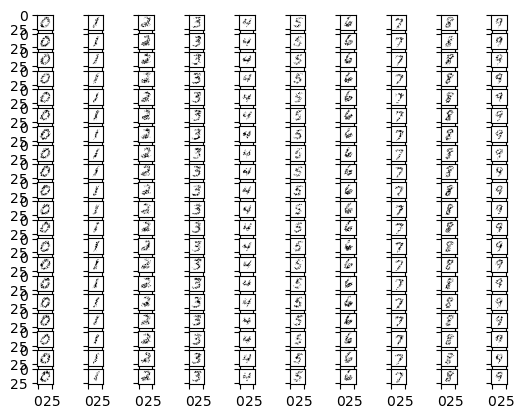

0.756  accuracy in binary
784 features


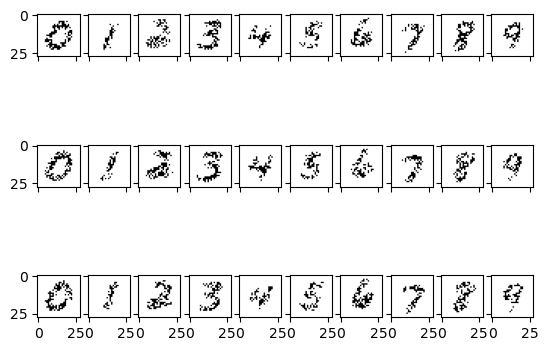

In [16]:
def P10(num_examples):

### STUDENT START ###
    # create binary data
    binary_mini_train_data = []
    for pic in mini_train_data:
        binary_mini_train_data.append(pic//.5)

    binary_dev_data = []
    for pic in dev_data:
        binary_dev_data.append(pic//.5)

    classifier = BernoulliNB()
    classifier.fit(binary_mini_train_data, mini_train_labels)
    predicted = classifier.predict(binary_dev_data)
    accuracy = sum(predicted == dev_labels)*1./len(dev_labels)
    print (accuracy, " accuracy in binary")
    print (len(classifier.feature_log_prob_[1]), "features")
    regen_weights = np.exp(classifier.feature_log_prob_)

    # generate pics
    samples = []
    for i in range(num_examples):
        ##
        generated_numbers = []
        for number in range(10):

            genpic = []
            for feature in regen_weights[number]:
                genpic.append(sqrt(feature*np.random.rand(1,1))//.5)
            generated_numbers.append(genpic)
        samples.append(generated_numbers)

    # plot pics
    f, plots = plt.subplots(len(samples),len(samples[0]), sharex='col', sharey='row')
    for i, plotrow in enumerate(plots):
        for j, subplot in enumerate(plotrow):
            plots[i][j].imshow(numpy.reshape(samples[i][j],(28,28)),cmap="Greys")
    plt.show()




### STUDENT END ###

P10(20)
P10(3)

ANSWER: 10x20 is too many examples for this screen, but zoomed in (or in the second chart only with 3 examples), the images are very pixelated, with random dots, like a staticy TV channel, which makes sense since a TV with static/noise is having its signal go through an analog version of regenerating the picture (here probabilities, which are already "staticy") with added noise/static (here, the np.rand factor).

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [17]:
def P11(buckets, correct, total):

### STUDENT START ###

        # create binary data
    binary_mini_train_data = []
    for pic in mini_train_data:
        binary_mini_train_data.append(pic//.5)

    binary_dev_data = []
    for pic in dev_data:
        binary_dev_data.append(pic//.5)

        # create classifier
    classifier = BernoulliNB()
    classifier.fit(binary_mini_train_data, mini_train_labels)
    predicted = classifier.predict(binary_dev_data)
    accuracy = sum(predicted == dev_labels)*1./len(dev_labels)
    print (accuracy, " accuracy in binary")

    #get probability bin data
    probs = classifier.predict_proba(binary_dev_data)
    for j,p in enumerate(probs):
        maxp = max(p)
        for i,bucket in enumerate(buckets):
            if maxp <= bucket:
                #print maxp,"<=",bucket
                total[i] +=1
                if predicted[j]==dev_labels[j]:
                    #print predicted[j],dev_labels[j]
                    correct[i] +=1.
                break
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]
P11(buckets, correct, total)
#print total
#print correct

for i in range(len(buckets)):
    accuracy = 0.
    if (total[i] > 0): accuracy = correct[i]/ total[i]
    print ('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

0.756  accuracy in binary
p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  63    accuracy = 0.365
p(pred) <= 0.9990000000000    total = 114    accuracy = 0.561
p(pred) <= 0.9999900000000    total = 105    accuracy = 0.571
p(pred) <= 0.9999999000000    total =  88    accuracy = 0.625
p(pred) <= 0.9999999990000    total = 100    accuracy = 0.700
p(pred) <= 0.9999999999900    total =  69    accuracy = 0.725
p(pred) <= 0.9999999999999    total =  61    accuracy = 0.820
p(pred) <= 1.0000000000000    total = 400    accuracy = 0.960


ANSWER: weakly calibrated, total!accuracy is not linear

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [18]:
def P12():
### STUDENT START ###
    # create binary data
    binary_mini_train_data = []
    for pic in mini_train_data:
        binary_mini_train_data.append(pic//.5)

    binary_dev_data = []
    for pic in dev_data:
        binary_dev_data.append(pic//.5)

    # create classifier, calculate initial accuracy
    classifier = BernoulliNB()
    classifier.fit(binary_mini_train_data, mini_train_labels)
    predicted = classifier.predict(binary_dev_data)
    accuracy = sum(predicted == dev_labels)*1./len(dev_labels)
    print (accuracy, " accuracy in binary")

    # calculate accuracy of individual pixels
    #penalty when wrong = half of points when right

    #init empty matrix
    pixel_accuracy = binary_mini_train_data[1]*0

    #score data points (pixels)
    for j,pic in enumerate(binary_dev_data):
        for i,pixel in enumerate(pic):
            if (pixel>0):
                if(dev_labels[j]==predicted[j]):
                    pixel_accuracy[i]+=2
                else:
                    pixel_accuracy[i]-=1

    #normalize, set cut-off level (cut lowers 25%)
    pixel_accuracy-= min(pixel_accuracy)
    theshold_weight = max(list(pixel_accuracy))/4
    pixel_accuracy-=theshold_weight

    #apply cut-off/threshold
    for n,pixel in enumerate(pixel_accuracy):
        if pixel>0:
            pixel_accuracy[n]=1
        if pixel<0:
            pixel_accuracy[n]=0


    #create data set with
    #filter applied to low accuracy pixels
    filtered_data=[]
    for pic in binary_mini_train_data:
        filtered_data.append(pic*pixel_accuracy)

        #evaluate new model
    classifier.fit(filtered_data, mini_train_labels)
    predicted = classifier.predict(binary_dev_data)
    accuracy = sum(predicted == dev_labels)*1./len(dev_labels)
    print (accuracy, " new accuracy - with low accuracy pixels removed")

### STUDENT END ###

P12()

0.756  accuracy in binary
0.726  new accuracy - with low accuracy pixels removed
